# Zipline Quickstart: Sharadar Bundle with FlightLog

This notebook demonstrates:
1. How to verify Sharadar bundle is registered
2. How to run a simple backtest
3. How to use FlightLog for real-time log monitoring
4. How to use progress logging for backtest metrics

## Prerequisites

Before running this notebook:
1. Ensure FlightLog server is running (check terminal on port 9020)
2. Sharadar data should be ingested: `!zipline ingest -b sharadar`
3. NASDAQ_DATA_LINK_API_KEY should be set in your .env file

## Step 1: Verify Bundle Registration

In [1]:
# Register Sharadar bundle (required for Jupyter notebooks)
from zipline.data.bundles import register
from zipline.data.bundles.sharadar_bundle import sharadar_bundle

# Register the main Sharadar bundle
register(
    'sharadar',
    sharadar_bundle(
        tickers=None,  # All tickers
        incremental=True,
        include_funds=True,
    ),
)

print("✓ Sharadar bundle registered")

✓ Sharadar bundle registered


In [2]:
from zipline.data.bundles import bundles

# Check what bundles are registered
print("Registered bundles:")
for bundle_name in bundles:
    print(f"  - {bundle_name}")

# Verify sharadar is registered
if 'sharadar' in bundles:
    print("\n✅ Sharadar bundle is registered!")
else:
    print("\n❌ Sharadar bundle NOT found!")
    print("\nTroubleshooting:")
    print("1. Check if ~/.zipline/extension.py exists")
    print("2. Restart Jupyter kernel")
    print("3. Check for import errors in extension.py")

Registered bundles:
  - quandl
  - quantopian-quandl
  - csvdir
  - sharadar

✅ Sharadar bundle is registered!


## Step 2: Check if Data is Ingested

In [3]:
import os
from pathlib import Path

zipline_root = Path.home() / '.zipline'
sharadar_data = zipline_root / 'data' / 'sharadar'

print(f"Checking for data in: {sharadar_data}")

if sharadar_data.exists():
    print("\n✅ Sharadar data directory found!")
    
    # List ingestions
    ingestions = list(sharadar_data.glob('*'))
    print(f"\nNumber of ingestions: {len(ingestions)}")
    
    if ingestions:
        latest = max(ingestions, key=lambda p: p.stat().st_mtime)
        print(f"Latest ingestion: {latest.name}")
        print(f"\nFiles in latest ingestion:")
        for f in latest.iterdir():
            size_mb = f.stat().st_size / (1024*1024) if f.is_file() else 0
            print(f"  - {f.name:<30} {size_mb:>8.1f} MB" if f.is_file() else f"  - {f.name}/")
else:
    print("\n❌ Sharadar data NOT found!")
    print("\nYou need to ingest data first:")
    print("  !zipline ingest -b sharadar")
    print("\nNote: First ingestion takes 60-90 minutes (downloads 1998-present)")
    print("      Subsequent ingestions take 2-5 minutes (incremental updates)")

Checking for data in: /root/.zipline/data/sharadar

✅ Sharadar data directory found!

Number of ingestions: 4
Latest ingestion: 2025-11-18T06;12;45.972010

Files in latest ingestion:
  - assets-7.sqlite                     5.4 MB
  - adjustments.sqlite                  0.1 MB
  - daily_equities.bcolz/
  - fundamentals/
  - minute_equities.bcolz/


## Step 3: Setup FlightLog (Optional)

FlightLog allows you to see logs in real-time in a separate terminal.

**If using Docker:**
1. Open a second terminal
2. Run: `docker logs -f zipline-flightlog`
3. You'll see colorized logs streaming in real-time

In [4]:
import logging
from zipline.utils.flightlog_client import enable_flightlog, log_to_flightlog

# Setup logging
logging.basicConfig(level=logging.INFO)

# Enable FlightLog (connects to localhost:9020)
try:
    enable_flightlog(host='localhost', port=9020)
    log_to_flightlog('FlightLog connected successfully!', level='INFO')
    print("✅ FlightLog enabled - check your second terminal!")
except Exception as e:
    print(f"⚠️  FlightLog not available: {e}")
    print("   Continuing without FlightLog...")

INFO:algorithm:FlightLog connected successfully!


✅ FlightLog enabled - check your second terminal!


## Step 4: Enable Progress Logging

Progress logging shows real-time backtest metrics (like QuantRocket):
- Progress bar
- Current date
- Cumulative returns
- Sharpe ratio
- Max drawdown
- Cumulative PNL

In [5]:
from zipline.utils.progress import enable_progress_logging

# Enable progress logging (update every 5 days)
enable_progress_logging(
    algo_name='QuickStart',
    update_interval=5  # Show progress every 5 trading days
)

print("✅ Progress logging enabled")

✅ Progress logging enabled


## Step 5: Define a Simple Trading Strategy

Let's create a simple buy-and-hold strategy for AAPL.

In [6]:
from zipline.api import (
    order_target_percent,
    symbol,
    set_benchmark,
    record,
)

def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    log_to_flightlog('🚀 Initializing QuickStart strategy', level='INFO')
    
    # Set our stock
    context.stock = symbol('AAPL')
    
    # Set benchmark
    set_benchmark(symbol('SPY'))
    
    # Track if we've bought
    context.bought = False
    
    log_to_flightlog('Configuration: Buy and hold AAPL', level='INFO')


def handle_data(context, data):
    """
    Called every trading day.
    """
    # Buy AAPL on first day if we haven't already
    if not context.bought:
        if data.can_trade(context.stock):
            # Invest 95% of portfolio in AAPL
            order_target_percent(context.stock, 0.95)
            context.bought = True
            
            log_to_flightlog(
                f'📈 Purchased AAPL at {data.current(context.stock, "price"):.2f}',
                level='INFO'
            )
    
    # Record current price for plotting
    record(
        AAPL=data.current(context.stock, 'price'),
        portfolio_value=context.portfolio.portfolio_value,
    )


def analyze(context, perf):
    """
    Called once at the end of the backtest.
    """
    log_to_flightlog('✅ Backtest completed!', level='INFO')
    
    # Print summary statistics
    print("\n" + "="*60)
    print("BACKTEST SUMMARY")
    print("="*60)
    
    final_value = perf['portfolio_value'].iloc[-1]
    total_return = (final_value / 10000 - 1) * 100  # Assuming $10k starting capital
    
    print(f"Final Portfolio Value: ${final_value:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Sharpe Ratio: {perf['sharpe'].iloc[-1]:.3f}")
    print(f"Max Drawdown: {perf['max_drawdown'].iloc[-1]*100:.2f}%")
    print(f"\nNumber of trades: {len(perf[perf['orders'] != '[]'])}")
    print("="*60)

In [7]:
from zipline import run_algorithm
import pandas as pd

# Define backtest period
start = pd.Timestamp('2020-01-01')
end = pd.Timestamp('2024-01-01')

print(f"Running backtest from {start.date()} to {end.date()}...\n")

# Run the backtest
results = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    handle_data=handle_data,
    analyze=analyze,
    capital_base=10000,
    data_frequency='daily',
    bundle='sharadar',
)

print("\n✅ Backtest complete!")

Running backtest from 2020-01-01 to 2024-01-01...

⚠ Yahoo Finance bundles not available: No module named 'zipline.data.bundles.yahoo_bundle'
⚠ NASDAQ Data Link bundles not available: No module named 'zipline.data.bundles.nasdaq_bundle'
✓ Sharadar bundles registered

Available bundles:
  - yahoo, yahoo-tech, yahoo-dow, yahoo-sp500
  - nasdaq, nasdaq-premium, nasdaq-free, nasdaq-sp500
  - sharadar, sharadar-tech, sharadar-sp500, sharadar-all

Use 'zipline bundles' to see which bundles have been ingested.


/root/.zipline/extension.py:56: UserWarning: Overwriting bundle with name 'sharadar'
  register('sharadar', sharadar_bundle())


2025-11-18 07:36:51,993 INFO zipline.progress: [QuickStart] Backtest initialized: 2020-01-02 to 2023-12-29 (1006 trading days)
2025-11-18 07:36:51,994 INFO zipline.progress: [QuickStart] Progress      Pct    Date             Cum Returns        Sharpe      Max DD             Cum PNL


INFO:algorithm:🚀 Initializing QuickStart strategy
INFO:algorithm:Configuration: Buy and hold AAPL
INFO:algorithm:📈 Purchased AAPL at 72.48


2025-11-18 07:36:52,516 INFO zipline.progress: [QuickStart] ----------      0%  2020-01-08              2%          7.23         -0%                $177
2025-11-18 07:36:52,518 INFO zipline.progress: [QuickStart] ----------      0%  2020-01-15              4%          6.18         -2%                $435
2025-11-18 07:36:52,521 INFO zipline.progress: [QuickStart] ----------      1%  2020-01-23              7%          7.31         -2%                $684
2025-11-18 07:36:52,523 INFO zipline.progress: [QuickStart] ----------      1%  2020-01-30              8%          5.02         -3%                $831
2025-11-18 07:36:52,525 INFO zipline.progress: [QuickStart] ----------      2%  2020-02-06              9%          3.46         -5%                $873
2025-11-18 07:36:52,527 INFO zipline.progress: [QuickStart] ----------      2%  2020-02-13              9%          3.04         -5%                $887
2025-11-18 07:36:52,529 INFO zipline.progress: [QuickStart] ----------      3%  20

INFO:zipline.finance.metrics.tracker:Simulated 1006 trading days
 first open: 2020-01-02 14:30:00+00:00
 last close: 2023-12-29 21:00:00+00:00


2025-11-18 07:36:53,031 INFO zipline.progress: 
[QuickStart] ==================================================
2025-11-18 07:36:53,031 INFO zipline.progress: [QuickStart] Backtest Complete!
2025-11-18 07:36:53,032 INFO zipline.progress: [QuickStart] ==================================================
2025-11-18 07:36:53,032 INFO zipline.progress: [QuickStart] Trading Days:     1006
2025-11-18 07:36:53,032 INFO zipline.progress: [QuickStart] Total Return:     +155.81%
2025-11-18 07:36:53,032 INFO zipline.progress: [QuickStart] Sharpe Ratio:     0.89
2025-11-18 07:36:53,033 INFO zipline.progress: [QuickStart] Max Drawdown:     -30.1%
2025-11-18 07:36:53,033 INFO zipline.progress: [QuickStart] Final Value:      $25,581
2025-11-18 07:36:53,033 INFO zipline.progress: [QuickStart] ==================================================



INFO:algorithm:✅ Backtest completed!



BACKTEST SUMMARY
Final Portfolio Value: $25,580.63
Total Return: 155.81%
Sharpe Ratio: 0.893
Max Drawdown: -30.15%

Number of trades: 1006

✅ Backtest complete!


## Step 7: Analyze Results

INFO:matplotlib.font_manager:generated new fontManager


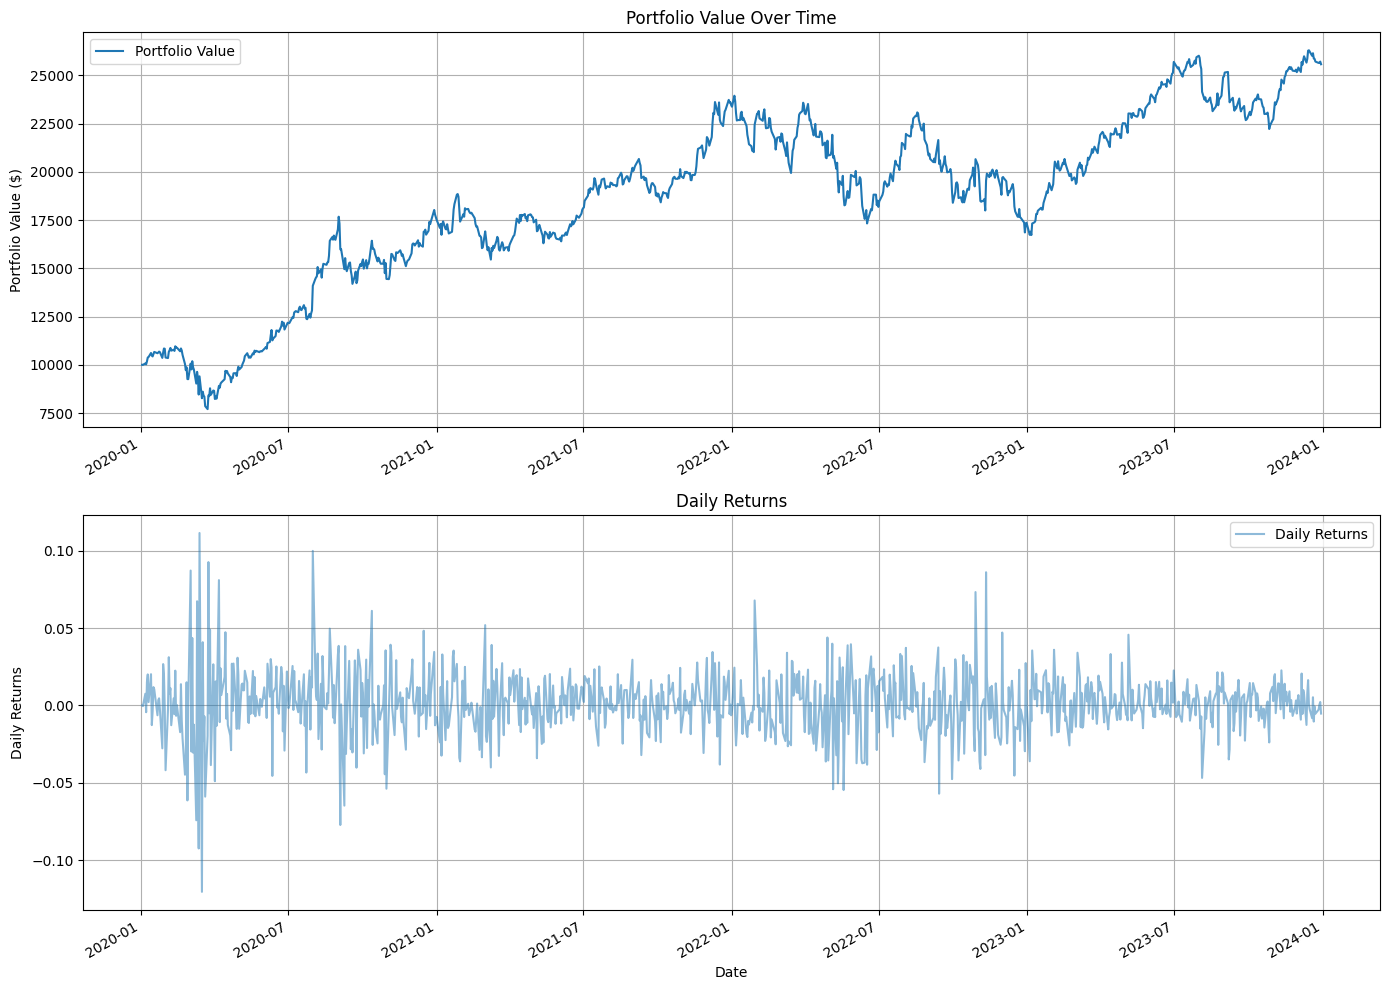


Key Statistics:
  Start Date: 2020-01-02
  End Date: 2023-12-29
  Total Days: 1006
  Final Value: $25,580.63
  Total Return: 155.81%
  Sharpe Ratio: 0.893
  Max Drawdown: -30.15%
  Volatility: 32.13%


In [8]:
import matplotlib.pyplot as plt

# Plot portfolio value over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Portfolio value
results['portfolio_value'].plot(ax=ax1, label='Portfolio Value')
ax1.set_ylabel('Portfolio Value ($)')
ax1.set_title('Portfolio Value Over Time')
ax1.legend()
ax1.grid(True)

# Returns
results['returns'].plot(ax=ax2, label='Daily Returns', alpha=0.5)
ax2.set_ylabel('Daily Returns')
ax2.set_xlabel('Date')
ax2.set_title('Daily Returns')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Show key statistics
print("\nKey Statistics:")
print(f"  Start Date: {results.index[0].date()}")
print(f"  End Date: {results.index[-1].date()}")
print(f"  Total Days: {len(results)}")
print(f"  Final Value: ${results['portfolio_value'].iloc[-1]:,.2f}")
print(f"  Total Return: {(results['portfolio_value'].iloc[-1]/10000 - 1)*100:.2f}%")
print(f"  Sharpe Ratio: {results['sharpe'].iloc[-1]:.3f}")
print(f"  Max Drawdown: {results['max_drawdown'].iloc[-1]*100:.2f}%")
print(f"  Volatility: {results['algo_volatility'].iloc[-1]*100:.2f}%")

## Next Steps

Now that you have a working setup, explore these examples:

1. **Production Strategy Example:**
   ```bash
   python examples/momentum_strategy_with_flightlog.py
   ```

2. **Simple Demo:**
   ```bash
   python examples/simple_flightlog_demo.py
   ```

3. **Documentation:**
   - `docs/FLIGHTLOG_BEST_PRACTICES.md` - FlightLog patterns
   - `docs/SHARADAR_GUIDE.md` - Sharadar usage
   - `GETTING_STARTED.md` - Quick start guide

4. **Daily Data Updates:**
   ```bash
   zipline ingest -b sharadar
   ```
   Takes only 2-5 minutes after first ingestion!

## Troubleshooting

### Bundle Not Found Error
```python
UnknownBundle: No bundle registered with the name 'sharadar'
```

**Solution:**
1. Check if `~/.zipline/extension.py` exists
2. Restart Jupyter kernel (Kernel → Restart Kernel)
3. Re-run Step 1 to verify registration

### FlightLog Connection Error
```python
ConnectionRefusedError: [Errno 111] Connection refused
```

**Solution:**
1. Check FlightLog is running: `docker ps | grep flightlog`
2. Check logs: `docker logs zipline-flightlog`
3. Restart FlightLog: `docker compose restart flightlog`

### No Data Found
```python
NoDataOnDate: No data on 2020-01-01
```

**Solution:**
1. Ingest data: `!zipline ingest -b sharadar`
2. Check data exists: Run Step 2 above
3. Wait for first ingestion to complete (60-90 min)